### Notebook for clustering 6mpi cardiac leucocytes from scratch

#### Environment: Scanpy

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240320
- **Last modified**: 240320

##### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt

##### Load in demultiplexed & merged data set (Pkp2+Ttn)

In [4]:
adata = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge_demux_QCed_ac240220.raw.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt_norm'

### Preprocessing

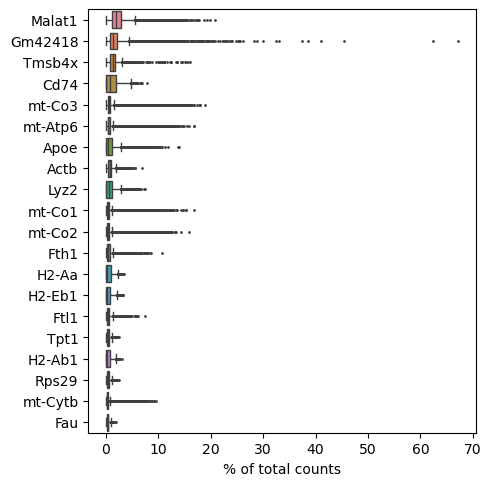

In [5]:
# show the genes that yield the highest fraction of counts across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

##### Basic filtering

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=100)